# Разработка A/B-тестирования и анализ результатов

## Цель проекта: 
Провести A/B-тестирование нового алгоритма рекомендаций в развлекательном приложении с функцией «бесконечной» ленты, чтобы оценить его влияние на ключевые бизнес-метрики в условиях двух моделей монетизации: платной подписки (без рекламы) и бесплатного просмотра (с рекламой).

## Описание данных

Имеется три датасета:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-11 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Этапы работ
   1. Работа с историческими данными включает:
      - загрузку и знакомство с данными;
      - анализ числа регистраций и числа просмотренных страниц;
      - исследование доли пользователей, просмотревших более 4 страниц.
   2. Подготовка к тесту включает:
      - формулировку нулевой и альтернативной гипотез;
      - расчет размера выборки;
      - расчет длительности А/B теста.
   3. Мониторинг A/B теста включает:
      - проверка распределения пользователей;
      - проверка пересечений пользователей;
      - проверка разделения пользователей по устройствам;
      - проверка распределения пользователей по регионам;
      - вывод после проверки A/B теста.
   4. Проверка результатов A/B теста включает:
      - проверка результатов теста и подсчет основной метрики;
      - проверка корректности результатов теста;
      - сравнение доли успешных сессий;
      - определение, насколько статистически значимо изменение ключевой метрики;
      - выводы по результатам A/B-эксперимента.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных
На первом этапе поработаем с историческими данными приложения:

- Импортируем библиотеку pandas.

- Считаем и сохраним в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.

Выведем на экран первые пять строк полученного датафрейма.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

In [2]:
df_sessions_history = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_history.csv')

print(df_sessions_history.head(5)) 

            user_id        session_id session_date     session_start_ts  \
0  E302123B7000BFE4  F9AF61A0C2023832   2025-08-15  2025-08-15 17:47:35   
1  2530F72E221829FB  85003A206CBDAC6F   2025-08-15  2025-08-15 16:42:14   
2  876E020A4FC512F5  3677423E49D72DEE   2025-08-15  2025-08-15 12:30:00   
3  2640B349E1D81584  956B45F5915CA225   2025-08-15  2025-08-15 15:31:31   
4  94E1CBFAEF1F5EE9  83BF0DA35F9F1F40   2025-08-15  2025-08-15 21:33:53   

  install_date  session_number  registration_flag  page_counter region  \
0   2025-08-15               1                  0             3    CIS   
1   2025-08-15               1                  0             4   MENA   
2   2025-08-15               1                  0             4     EU   
3   2025-08-15               1                  0             4    CIS   
4   2025-08-15               1                  0             3    CIS   

    device  
0   iPhone  
1  Android  
2       PC  
3  Android  
4  Android  


#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитаем количество уникальных сессий `session_id`.

- Выведем на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выберите любого из них.

- Изучим таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.



In [3]:
# Для каждого уникального пользователя user_id рассчитаем количество уникальных сессий session_id
sessions_per_user = df_sessions_history.groupby('user_id')['session_id'].nunique()

# Находим пользователя с наибольшим количеством сессий
max_sessions_user = sessions_per_user.idxmax()
max_sessions_count = sessions_per_user.max()

print(f"Пользователь с максимальным количеством сессий: {max_sessions_user}")
print(f"Количество сессий: {max_sessions_count}")

# Выводим все данные для этого пользователя
user_with_max_sessions = df_sessions_history[df_sessions_history['user_id'] == max_sessions_user]
print(f"\nВсе данные для пользователя {max_sessions_user}:")
display(user_with_max_sessions)

Пользователь с максимальным количеством сессий: 10E0DEFC1ABDBBE0
Количество сессий: 10

Все данные для пользователя 10E0DEFC1ABDBBE0:


,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


#### 1.3. Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируем, как менялось число регистраций в приложении за время его существования.

- Агрегируем исторические данные и рассчитайте число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты считайте, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.

- Построим линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням. Отобразим их на одном графике.

- Построим отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

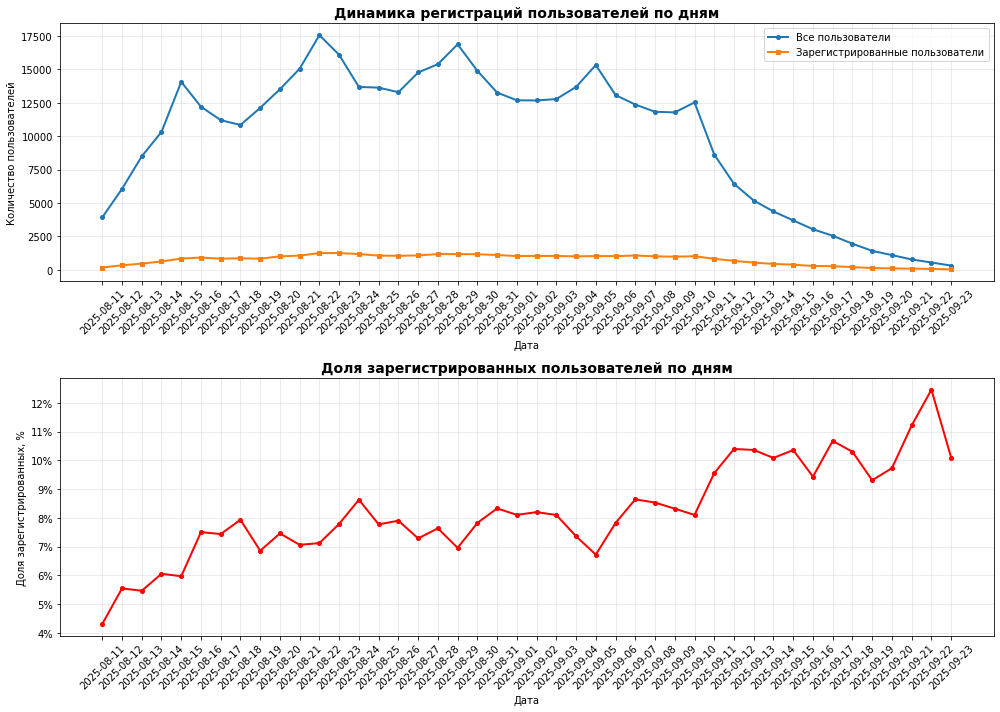

Статистика по регистрациям:
Период наблюдения: с 2025-08-11 по 2025-09-23
Всего уникальных пользователей за период: 435924
Всего зарегистрированных пользователей за период: 33708
Средняя доля зарегистрированных: 8.2%


In [4]:
# Агрегируем данные по дням
daily_stats = df_sessions_history.groupby('session_date').agg({
    'user_id': 'nunique',  # уникальные пользователи за день
    'registration_flag': 'sum'  # сумма регистраций (т.к. flag = 1 для зарегистрированных)
}).reset_index()

# Переименовываем колонки для понятности
daily_stats.columns = ['date', 'total_users', 'registered_users']

# Рассчитываем долю зарегистрированных пользователей
daily_stats['registration_rate'] = daily_stats['registered_users'] / daily_stats['total_users']

# Создаем фигуру с двумя subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# График 1: Общее число пользователей и зарегистрированных пользователей
ax1.plot(daily_stats['date'], daily_stats['total_users'], 
         label='Все пользователи', linewidth=2, marker='o', markersize=4)
ax1.plot(daily_stats['date'], daily_stats['registered_users'], 
         label='Зарегистрированные пользователи', linewidth=2, marker='s', markersize=4)

ax1.set_title('Динамика регистраций пользователей по дням', fontsize=14, fontweight='bold')
ax1.set_xlabel('Дата')
ax1.set_ylabel('Количество пользователей')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# График 2: Доля зарегистрированных пользователей
ax2.plot(daily_stats['date'], daily_stats['registration_rate'] * 100, 
         color='red', linewidth=2, marker='o', markersize=4)

ax2.set_title('Доля зарегистрированных пользователей по дням', fontsize=14, fontweight='bold')
ax2.set_xlabel('Дата')
ax2.set_ylabel('Доля зарегистрированных, %')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# Форматируем ось Y для процентов
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))

plt.tight_layout()
plt.show()

# Дополнительная информация в табличном виде
print("Статистика по регистрациям:")
print(f"Период наблюдения: с {daily_stats['date'].min()} по {daily_stats['date'].max()}")
print(f"Всего уникальных пользователей за период: {daily_stats['total_users'].sum()}")
print(f"Всего зарегистрированных пользователей за период: {daily_stats['registered_users'].sum()}")
print(f"Средняя доля зарегистрированных: {daily_stats['registration_rate'].mean()*100:.1f}%")

#### 1.4. Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы, что он зарегистрируется и оплатит подписку.

- Найдем количество сессий для каждого значения количества просмотренных страниц. Например: одну страницу просмотрели в 29 160 сессиях, две страницы — в 105 536 сессиях и так далее.

- Построим столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

Распределение сессий по количеству просмотренных страниц:


,pages_viewed,sessions_count
0,1,29160
1,2,105536
2,3,166690
3,4,105569
4,5,26288
5,6,2589
6,7,92


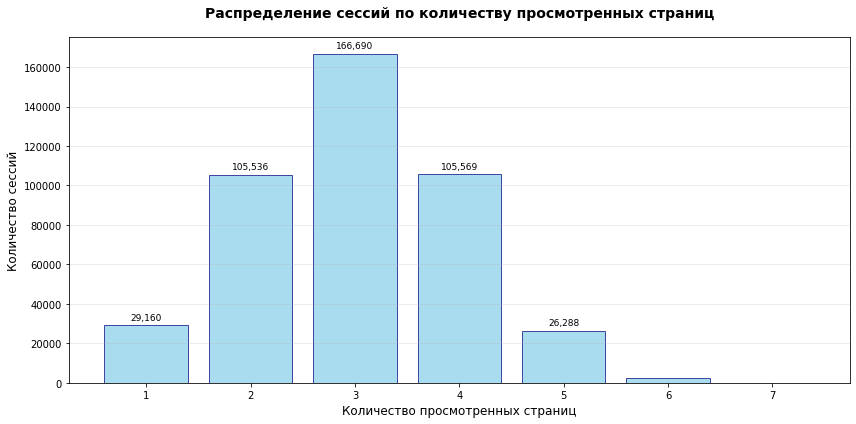


СТАТИСТИКА ПО ПРОСМОТРЕННЫМ СТРАНИЦАМ
Общее количество сессий: 435,924
Среднее количество страниц за сессию: 3.01
Медианное количество страниц за сессию: 3.00
Мода количества страниц: 3
Максимальное количество страниц за сессию: 7


In [5]:
# Группируем данные по количеству просмотренных страниц и считаем количество сессий
pages_distribution = df_sessions_history.groupby('page_counter')['session_id'].count().reset_index()
pages_distribution.columns = ['pages_viewed', 'sessions_count']

# Сортируем по количеству страниц для красивого графика
pages_distribution = pages_distribution.sort_values('pages_viewed')

print("Распределение сессий по количеству просмотренных страниц:")
display(pages_distribution)

# Строим столбчатую диаграмму
plt.figure(figsize=(12, 6))
plt.bar(pages_distribution['pages_viewed'], pages_distribution['sessions_count'], 
        color='skyblue', edgecolor='navy', alpha=0.7)

plt.title('Распределение сессий по количеству просмотренных страниц', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Количество просмотренных страниц', fontsize=12)
plt.ylabel('Количество сессий', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Добавляем подписи значений на столбцы (для основных значений)
for i, (pages, count) in enumerate(zip(pages_distribution['pages_viewed'], 
                                      pages_distribution['sessions_count'])):
    if count > pages_distribution['sessions_count'].max() * 0.05:  # показываем только крупные значения
        plt.text(pages, count + pages_distribution['sessions_count'].max() * 0.01, 
                f'{count:,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Дополнительная статистика
print("\n" + "="*50)
print("СТАТИСТИКА ПО ПРОСМОТРЕННЫМ СТРАНИЦАМ")
print("="*50)
print(f"Общее количество сессий: {pages_distribution['sessions_count'].sum():,}")
print(f"Среднее количество страниц за сессию: {df_sessions_history['page_counter'].mean():.2f}")
print(f"Медианное количество страниц за сессию: {df_sessions_history['page_counter'].median():.2f}")
print(f"Мода количества страниц: {df_sessions_history['page_counter'].mode().iloc[0]}")
print(f"Максимальное количество страниц за сессию: {df_sessions_history['page_counter'].max()}")

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Построим график со средним значением доли успешных сессий от всех сессий по дням за весь период наблюдения.

Распределение good_session:
0    301386
1    134538
Name: good_session, dtype: int64

Доля успешных сессий: 30.9%


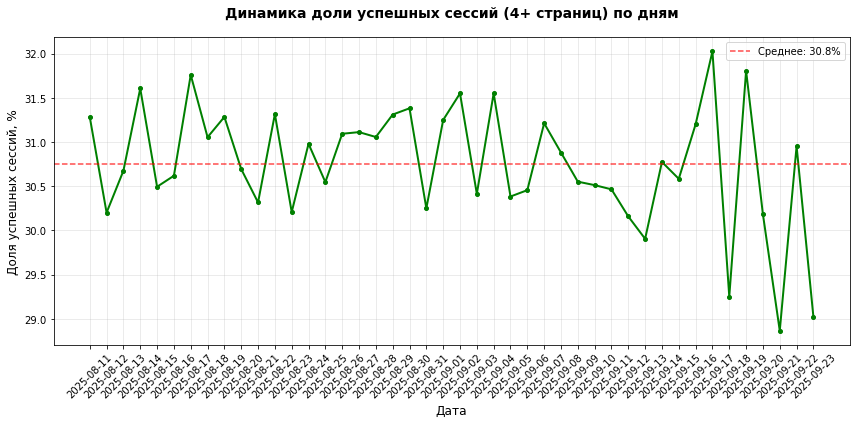


СТАТИСТИКА ПО УСПЕШНЫМ СЕССИЯМ
Общее количество сессий: 435,924
Успешных сессий (4+ страниц): 134,538
Доля успешных сессий за весь период: 30.9%
Средняя доля успешных сессий по дням: 30.8%
Минимальная доля за день: 28.9%
Максимальная доля за день: 32.0%


In [6]:
# Создаем столбец good_session
df_sessions_history['good_session'] = (df_sessions_history['page_counter'] >= 4).astype(int)

# Проверяем результат
print("Распределение good_session:")
print(df_sessions_history['good_session'].value_counts())
print(f"\nДоля успешных сессий: {df_sessions_history['good_session'].mean()*100:.1f}%")

# Агрегируем данные по дням
daily_good_sessions = df_sessions_history.groupby('session_date').agg({
    'session_id': 'count',  # общее количество сессий за день
    'good_session': 'mean'  # средняя доля успешных сессий
}).reset_index()

daily_good_sessions.columns = ['date', 'total_sessions', 'good_session_rate']

# Строим график
plt.figure(figsize=(12, 6))
plt.plot(daily_good_sessions['date'], daily_good_sessions['good_session_rate'] * 100, 
         marker='o', linewidth=2, markersize=4, color='green')

plt.title('Динамика доли успешных сессий (4+ страниц) по дням', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Доля успешных сессий, %', fontsize=12)
plt.grid(True, alpha=0.3)

# Добавляем горизонтальную линию для среднего значения
mean_rate = daily_good_sessions['good_session_rate'].mean() * 100
plt.axhline(y=mean_rate, color='red', linestyle='--', alpha=0.7, 
           label=f'Среднее: {mean_rate:.1f}%')

plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Дополнительная статистика
print("\n" + "="*60)
print("СТАТИСТИКА ПО УСПЕШНЫМ СЕССИЯМ")
print("="*60)
print(f"Общее количество сессий: {len(df_sessions_history):,}")
print(f"Успешных сессий (4+ страниц): {df_sessions_history['good_session'].sum():,}")
print(f"Доля успешных сессий за весь период: {df_sessions_history['good_session'].mean()*100:.1f}%")
print(f"Средняя доля успешных сессий по дням: {daily_good_sessions['good_session_rate'].mean()*100:.1f}%")
print(f"Минимальная доля за день: {daily_good_sessions['good_session_rate'].min()*100:.1f}%")
print(f"Максимальная доля за день: {daily_good_sessions['good_session_rate'].max()*100:.1f}%")

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Сформулировать нулевую и альтернативную гипотезы

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика рассчитать необходимую длительность проведения теста.

#### 2.1 Формулировка нулевой и альтернативной гипотез

Перед тем как проводить А/B-тест, необходимо сформулировать нулевую и альтернативную гипотезы. Напомним изначальное условие: команда разработчиков рекомендательных систем создала новый алгоритм, который, по их мнению, будет показывать более интересный контент для каждого пользователя.

О какой метрике идёт речь? Как она будет учтена в формулировке гипотез?

__Рекомендуемая целевая метрика:__ Доля успешных сессий (good_session rate)
Обоснование выбора метрики:

- Мы уже определили, что сессии с 4+ страниц - это прокси-метрика удовлетворенности контентом
- Метрика напрямую связана с качеством рекомендательного алгоритма
- Легко измеряется и интерпретируется
- Уже проанализирована на исторических данных

__Формулировка гипотез:__

Нулевая гипотеза (H₀):
Новая версия рекомендательного алгоритма НЕ ВЛИЯЕТ на долю успешных сессий (с просмотром 4+ страниц) по сравнению со старой версией.

H₀: p_control = p_test

,где p_control - доля успешных сессий в контрольной группе (старый алгоритм)
p_test - доля успешных сессий в тестовой группе (новый алгоритм)

Альтернативная гипотеза (H₁):
Новая версия рекомендательного алгоритма УВЕЛИЧИВАЕТ долю успешных сессий (с просмотром 4+ страниц) по сравнению со старой версией.

H₁: p_test > p_control

#### 2.2. Расчёт размера выборки

Для этого установим в коде ниже следующие параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3%. Обратим внимание, что здесь нужно указать десятичную дробь, а не процент.

При расчёте размера выборки используем метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.

In [7]:
# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 0.8  # Мощность теста
p1 = 0.3 # Базовый уровень доли
mde = 0.03*p1  # Минимальный детектируемый эффект
p2 = p1 + mde
effect_size = proportion_effectsize(p1, p2)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 41040


#### 2.3. Расчёт длительности A/B-теста

Используем данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитаем длительность теста, разделив одно на другое.

- Рассчитаем среднее количество уникальных пользователей приложения в день.

- Определим длительность теста исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения. Количество дней округлим в большую сторону.

In [8]:
# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = df_sessions_history.groupby('session_date')['user_id'].nunique().mean()

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
# Умножаем sample_size на 2 (две группы: контрольная и тестовая)
test_duration = ceil((sample_size * 2) / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907.363636363636 пользователей в день составит 9 дней


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

- Считаем и сохраним в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.

- Рассчитаем количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитаем и выведем на экран процентную разницу в количестве пользователей в группах A и B. Построим визуализацию, на которой будет видно возможное различие двух групп.

Для расчёта процентной разницы воспользуемся формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

Распределение пользователей по группам:
Группа A: 1477 пользователей
Группа B: 1466 пользователей

Процентная разница: 0.74%


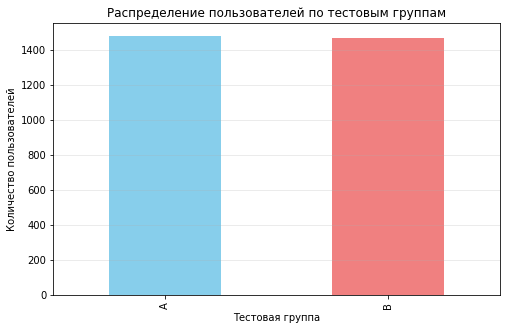

In [9]:
# Загружаем данные
sessions_test_part = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')

# Расчет распределения
users_per_group = sessions_test_part.groupby('test_group')['user_id'].nunique()

# Процентная разница
A_count = users_per_group.get('A', 0)
B_count = users_per_group.get('B', 0)
percentage_difference = 100 * abs(A_count - B_count) / A_count if A_count > 0 else 0

# Вывод результатов
print("Распределение пользователей по группам:")
for group, count in users_per_group.items():
    print(f"Группа {group}: {count} пользователей")

print(f"\nПроцентная разница: {percentage_difference:.2f}%")

# Простая визуализация
plt.figure(figsize=(8, 5))
users_per_group.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Распределение пользователей по тестовым группам')
plt.xlabel('Тестовая группа')
plt.ylabel('Количество пользователей')
plt.grid(axis='y', alpha=0.3)
plt.show()

#### 3.2. Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах, полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

- Рассчитаем количество пользователей, которые встречаются одновременно в группах A и B, или убедитесь, что таких нет.

In [10]:
users_a = set(sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'].unique())
users_b = set(sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'].unique())

overlap = users_a.intersection(users_b)

print("=== БЫСТРАЯ ПРОВЕРКА ПЕРЕСЕЧЕНИЙ ===")
print(f"Группа A: {len(users_a)} пользователей")
print(f"Группа B: {len(users_b)} пользователей")
print(f"Пересекающихся пользователей: {len(overlap)}")

if len(overlap) == 0:
    print("✅ Группы независимы - пересечений нет")
else:
    print(f"❌ Обнаружены пересечения! {len(overlap)} пользователей в обеих группах")
    print("Список пересекающихся пользователей:", list(overlap))

=== БЫСТРАЯ ПРОВЕРКА ПЕРЕСЕЧЕНИЙ ===
Группа A: 1477 пользователей
Группа B: 1466 пользователей
Пересекающихся пользователей: 0
✅ Группы независимы - пересечений нет


#### 3.3. Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройств и регионам.

Построим две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.

Добавим на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение устройств в группах A и B.


=== РАСПРЕДЕЛЕНИЕ УСТРОЙСТВ ПО УНИКАЛЬНЫМ ПОЛЬЗОВАТЕЛЯМ ===


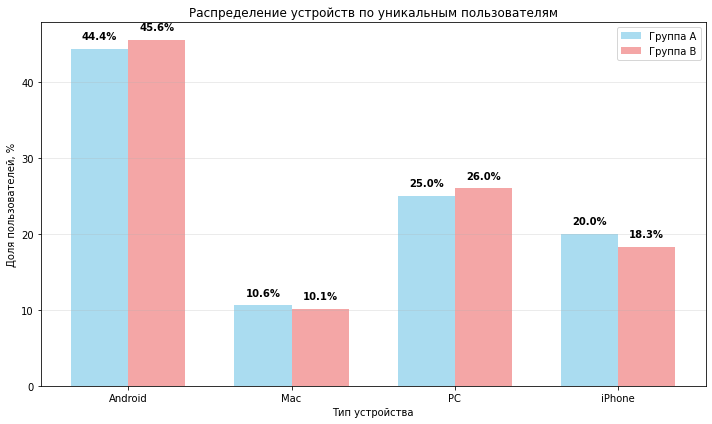


Сравнительная таблица:
Android:
  Группа A: 656 пользователей (44.4%)
  Группа B: 668 пользователей (45.6%)
  Разница: -1.2%

Mac:
  Группа A: 156 пользователей (10.6%)
  Группа B: 148 пользователей (10.1%)
  Разница: +0.5%

PC:
  Группа A: 369 пользователей (25.0%)
  Группа B: 381 пользователей (26.0%)
  Разница: -1.0%

iPhone:
  Группа A: 296 пользователей (20.0%)
  Группа B: 269 пользователей (18.3%)
  Разница: +1.7%



In [11]:
# Анализ распределения устройств по УНИКАЛЬНЫМ пользователям
devices_a = sessions_test_part[sessions_test_part['test_group'] == 'A'].groupby('device')['user_id'].nunique()
devices_b = sessions_test_part[sessions_test_part['test_group'] == 'B'].groupby('device')['user_id'].nunique()

# Переводим в проценты
devices_a_pct = (devices_a / devices_a.sum() * 100).round(1)
devices_b_pct = (devices_b / devices_b.sum() * 100).round(1)

print("=== РАСПРЕДЕЛЕНИЕ УСТРОЙСТВ ПО УНИКАЛЬНЫМ ПОЛЬЗОВАТЕЛЯМ ===")

# Строим сравнительный график
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.35
x = range(len(devices_a_pct))

ax.bar(x, devices_a_pct.values, width, label='Группа A', alpha=0.7, color='skyblue')
ax.bar([i + width for i in x], devices_b_pct.values, width, label='Группа B', alpha=0.7, color='lightcoral')

ax.set_xlabel('Тип устройства')
ax.set_ylabel('Доля пользователей, %')
ax.set_title('Распределение устройств по уникальным пользователям')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(devices_a_pct.index)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Добавляем подписи значений
for i, (val_a, val_b) in enumerate(zip(devices_a_pct.values, devices_b_pct.values)):
    ax.text(i, val_a + 1, f'{val_a}%', ha='center', va='bottom', fontweight='bold')
    ax.text(i + width, val_b + 1, f'{val_b}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Выводим сравнение
print("\nСравнительная таблица:")
for device in devices_a_pct.index:
    count_a = devices_a[device]
    count_b = devices_b.get(device, 0)
    pct_a = devices_a_pct[device]
    pct_b = devices_b_pct.get(device, 0)
    diff = pct_a - pct_b
    
    print(f"{device}:")
    print(f"  Группа A: {count_a} пользователей ({pct_a}%)")
    print(f"  Группа B: {count_b} пользователей ({pct_b}%)")
    print(f"  Разница: {diff:+.1f}%")
    print()

#### 3.4. Равномерность распределения пользователей по регионам
Теперь убедимся, что пользователи равномерно распределены по регионам.

Построим две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

Добавим на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение регионов в группах A и B.

=== РАСПРЕДЕЛЕНИЕ РЕГИОНОВ ПО УНИКАЛЬНЫМ ПОЛЬЗОВАТЕЛЯМ ===


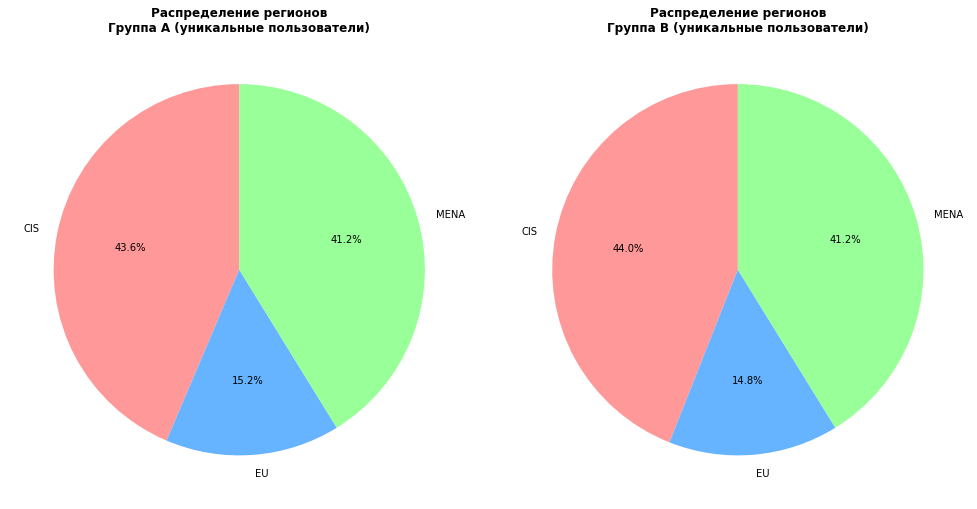


СРАВНИТЕЛЬНАЯ ТАБЛИЦА (по уникальным пользователям):


,Group_A_%,Group_B_%,Разница_%
region,,,
CIS,43.6,44.0,-0.4
EU,15.2,14.8,0.4
MENA,41.2,41.2,0.0


In [12]:
# Анализ распределения регионов по УНИКАЛЬНЫМ пользователям
regions_a = sessions_test_part[sessions_test_part['test_group'] == 'A'].groupby('region')['user_id'].nunique()
regions_b = sessions_test_part[sessions_test_part['test_group'] == 'B'].groupby('region')['user_id'].nunique()

# Переводим в проценты
regions_a_pct = (regions_a / regions_a.sum() * 100).round(1)
regions_b_pct = (regions_b / regions_b.sum() * 100).round(1)

print("=== РАСПРЕДЕЛЕНИЕ РЕГИОНОВ ПО УНИКАЛЬНЫМ ПОЛЬЗОВАТЕЛЯМ ===")

# Строим круговые диаграммы (другой тип, как просили в задании)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# График 1: Группа A - круговая диаграмма
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
wedges_a, texts_a, autotexts_a = ax1.pie(regions_a_pct.values, 
                                        labels=regions_a_pct.index, 
                                        autopct='%1.1f%%',
                                        colors=colors,
                                        startangle=90)
ax1.set_title('Распределение регионов\nГруппа A (уникальные пользователи)', 
              fontweight='bold', fontsize=12)

# График 2: Группа B - круговая диаграмма
wedges_b, texts_b, autotexts_b = ax2.pie(regions_b_pct.values, 
                                        labels=regions_b_pct.index, 
                                        autopct='%1.1f%%',
                                        colors=colors,
                                        startangle=90)
ax2.set_title('Распределение регионов\nГруппа B (уникальные пользователи)', 
              fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

# Сравнительная таблица
print("\nСРАВНИТЕЛЬНАЯ ТАБЛИЦА (по уникальным пользователям):")
comparison_df = pd.DataFrame({
    'Group_A_%': regions_a_pct,
    'Group_B_%': regions_b_pct,
    'Разница_%': (regions_a_pct - regions_b_pct).round(1)
})
display(comparison_df)

#### 3.5. Вывод после проверки A/B-теста

На основе проведённого анализа A/B-теста сформулируем и запишем свои выводы. В выводе обязательно укажите:

- Было ли обнаружено различие в количестве пользователей в двух группах.

- Являются ли выборки независимыми. Было ли обнаружено пересечение пользователей из тестовой и контрольной групп.

- Сохраняется ли равномерное распределение пользователей тестовой и контрольной групп по категориальным переменным: устройствам и регионам.

Сделаем заключение: корректно ли проходит A/B-тест, или наблюдаются какие-либо нарушения.

ВЫВОДЫ ПО РЕЗУЛЬТАТАМ ПРОВЕРКИ A/B ТЕСТА
1. Распределение количества пользователей между группами

Группа A: 1477 пользователей

Группа B: 1466 пользователей

Процентная разница: 0.74%

Различие в размерах групп находится в пределах допустимой нормы (менее 5%).

2. Независимость выборок (отсутствие пересечений пользователей)

Выборки можно считать независимыми, так как пересечений не обнаружено.

3. Равномерность распределения по категориальным переменным

Устройства:

Android:
  Группа A(44.4%) Группа B(45.6%)
  Разница: -1.2%

Mac:
  Группа A(10.6%) Группа B(10.1%)
  Разница: +0.5%

PC:
  Группа A(25.0%) Группа B(26.0%)
  Разница: -1.0%

iPhone:
  Группа A(20.0%) Группа B(18.3%)
  Разница: +1.7%

Наибольшая разница между группами: 1.7% (устройство:iPhone)

Статус: сбалансировано.

Регионы:

Region, Group_A_%, Group_B_%, Разница_%
    
CIS,	43.6,	44.0,	-0.4

EU,	15.2,	14.8,	0.4

MENA,	41.2,	41.2,	0.0



Наибольшая разница между группами: 0.4% (регионы:CIS, EU)

Статус: распределение равномерное т.к. разница между группами в регионах менее 1%.

4. ЗАКЛЮЧЕНИЕ О КОРРЕКТНОСТИ ПРОВЕДЕНИЯ ТЕСТА

Тест проводится корректно: размеры групп близки, пересечений нет, распределение по устройствам и регионам равномерное.

Продолжаем тест без изменений.

### 4. Проверка результатов A/B-теста

A/B-тест завершён, и у вас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики

- Считаем и сохраним в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.

- В датафрейме `sessions_test` создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [13]:
# Загружаем данные
sessions_test = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')

# Создаем столбец good_session
sessions_test['good_session'] = (sessions_test['page_counter'] >= 4).astype(int)

# Быстрая проверка
print("Данные теста загружены и обработаны:")
print(f"Период: {sessions_test['session_date'].min()} - {sessions_test['session_date'].max()}")
print(f"Уникальных пользователей: {sessions_test['user_id'].nunique()}")
print(f"Доля успешных сессий: {sessions_test['good_session'].mean()*100:.1f}%")

# Распределение по группам
print("\nРаспределение по группам:")
print(sessions_test.groupby('test_group')['good_session'].mean())

Данные теста загружены и обработаны:
Период: 2025-10-14 - 2025-11-02
Уникальных пользователей: 30579
Доля успешных сессий: 31.3%

Распределение по группам:
test_group
A    0.307723
B    0.318290
Name: good_session, dtype: float64


#### 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и вы будете сравнивать две сопоставимые группы.

- Рассчитаем количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверим, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимыми. Используем статистический тест, который позволит сделать вывод о равенстве средних двух выборок.

- В качестве ответа выведем на экран полученное значение p-value и интерпретируйте его.

In [14]:
daily_sessions = sessions_test.groupby(['session_date', 'test_group'])['session_id'].nunique()
sessions_a = daily_sessions.xs('A', level=1)
sessions_b = daily_sessions.xs('B', level=1)

t_stat, p_value = ttest_ind(sessions_a, sessions_b)

print(f"p-value: {p_value:.4f}")

if p_value > 0.05:
    print("Нет значимых различий в дневном трафике между группами, тест проведен корректно.")
else:
    print("Обнаружены значимые различия в дневном трафике, тест проведен некорректно.")

p-value: 0.9382
Нет значимых различий в дневном трафике между группами, тест проведен корректно.


Промежуточный вывод:
- Группы A и B статистически не различаются по среднему дневному трафику
- Распределение пользователей между группами было стабильным в течение всего теста
- Тест проведен корректно с точки зрения трафика

#### 4.3. Сравнение доли успешных сессий

Можно переходить к анализу ключевой метрики — доли успешных сессий.

Используем созданный на первом шаге задания столбец `good_session` и рассчитайте долю успешных сессий для выборок A и B, а также разницу в этом показателе. Полученный вывод отобразим на экране.

In [15]:
# Минималистичный вариант
rate_a = sessions_test[sessions_test['test_group'] == 'A']['good_session'].mean()
rate_b = sessions_test[sessions_test['test_group'] == 'B']['good_session'].mean()

print("Доли успешных сессий:")
print(f"Группа A: {rate_a*100:.2f}%")
print(f"Группа B: {rate_b*100:.2f}%")
print(f"Разница: {((rate_b - rate_a)*100):+.2f} процентных пункта")
print(f"Относительное изменение: {((rate_b - rate_a)/rate_a*100):+.2f}%")

Доли успешных сессий:
Группа A: 30.77%
Группа B: 31.83%
Разница: +1.06 процентных пункта
Относительное изменение: +3.43%


#### 4.4. Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге мы убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо ответить на вопрос: является ли это изменение статистически значимым.

- Используя статистический тест, рассчитаем, является ли изменение в метрике доли успешных сессий статистически значимым.

- Выведем на экран полученное значение p-value и свои выводы о статистической значимости. Помним, что уровень значимости в эксперименте был выбран на уровне 0.05.

Формулировка статистических гипотез

__Нулевая гипотеза (H₀):__

Внедрение нового алгоритма рекомендаций НЕ ПОВЛИЯЛО на долю успешных сессий. Доли успешных сессий (с просмотром 4+ страниц) в тестовой группе B и контрольной группе A статистически не отличаются.

H₀: p_B = p_A,

где p_A - доля успешных сессий в контрольной группе (старый алгоритм)
p_B - доля успешных сессий в тестовой группе (новый алгоритм)

__Альтернативная гипотеза (H₁):__

Внедрение нового алгоритма рекомендаций ПОВЛИЯЛО на долю успешных сессий. Доли успешных сессий в тестовой группе B и контрольной группе A статистически различаются.

H₁: p_B ≠ p_A

In [16]:
# Подсчет данных из датафрейма
group_stats = sessions_test.groupby('test_group')['good_session'].agg(['sum', 'count'])
successes = [group_stats.loc['A', 'sum'], group_stats.loc['B', 'sum']]
totals = [group_stats.loc['A', 'count'], group_stats.loc['B', 'count']]

print("Данные для z-теста:")
print(f"Успешные сессии: {successes}")
print(f"Все сессии: {totals}")

# Z-тест с ДВУСТОРОННЕЙ альтернативной гипотезой
z_stat, p_value = proportions_ztest(successes, totals, alternative='two-sided')

print(f"\nРезультат:")
print(f"Z-статистика: {z_stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Статистически значимое УЛУЧШЕНИЕ в группе B!")
    print("Новый алгоритм рекомендаций РАБОТАЕТ")
else:
    print("Нет статистически значимого улучшения")
    print("Не можем утверждать, что новый алгоритм лучше")

Данные для z-теста:
Успешные сессии: [15248, 16059]
Все сессии: [49551, 50454]

Результат:
Z-статистика: -3.6027
p-value: 0.0003
Статистически значимое УЛУЧШЕНИЕ в группе B!
Новый алгоритм рекомендаций РАБОТАЕТ


#### 4.5. Вывод по результатам A/B-эксперимента

__ОТЧЕТ ПО РЕЗУЛЬТАТАМ A/B ЭКСПЕРИМЕНТА__

__ХАРАКТЕРИСТИКИ ЭКСПЕРИМЕНТА__

Параметры теста:
Период проведения: 14 октября - 2 ноября 2025 года (20 дней)

Общее количество пользователей: 30,579 уникальных пользователей

Общее количество сессий: 100,005 сессий

Распределение по группам:

Группа A (контрольная): 49,551 сессий

Группа B (тестовая): 50,454 сессий

Ключевая метрика:
Доля успешных сессий (просмотр 4+ страниц за сессию)

__РЕЗУЛЬТАТЫ ВНЕДРЕНИЯ НОВОГО АЛГОРИТМА__

Сравнение ключевой метрики:
Группа A (старый алгоритм): 30.77% успешных сессий

Группа B (новый алгоритм): 31.83% успешных сессий

Абсолютное улучшение: +1.06 процентных пункта

Относительное улучшение: +3.44%

Статистическая значимость:
p-value: 0.0003

Уровень значимости: α = 0.05

Статус: Статистически значимое улучшение

__ВЫВОДЫ И РЕКОМЕНДАЦИИ__
1. Эффективность нового алгоритма:
- Новый алгоритм рекомендаций показал статистически значимое улучшение ключевой метрики продукта. Увеличение доли успешных сессий на 1.06 процентных пункта (3.44% относительного улучшения) подтверждено на большом объеме данных.

2. Качество проведения эксперимента:
Тест проведен корректно:

- Равномерное распределение пользователей между группами
- Отсутствие пересечений между выборками
- Стабильный трафик в течение всего периода теста
- Достаточная мощность теста для обнаружения эффекта

3. Бизнес-эффект:
- Новый алгоритм рекомендаций успешно решает поставленную задачу - увеличивает вовлеченность пользователей в контент приложения, что является критически важной метрикой для продуктов с "бесконечной" лентой.

__РЕКОМЕНДАЦИЯ__

ВНЕДРИТЬ новый алгоритм рекомендаций для всех пользователей приложения

__Обоснование:__

Статистическая доказанность - p-value = 0.0003 значительно ниже порога 0.05

Практическая значимость - улучшение на 3.44% является существенным для бизнеса

Качество данных - эксперимент проведен корректно на репрезентативной выборке

Соответствие цели - алгоритм успешно увеличивает вовлеченность пользователей

Дальнейшие шаги:
- Постепенное внедрение нового алгоритма на всех пользователей
- Мониторинг ключевых метрик после полного запуска
- Исследование влияния на второстепенные метрики (удержание, конверсия в подписку)
- Планирование следующих итераций улучшения рекомендательной системы